## 安徽观测数据处理分析
## `Observation data in Anhui`

---
*@author: Evan*\
*@date: 2023-03-06*

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import os

In [3]:
# silence the warning note
import warnings
warnings.filterwarnings("ignore")

In [4]:
from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'], # simsun字体中文版就是宋体
}
rcParams.update(config)

In [5]:
folder_path='D:/files/Master/02学术/横向项目_安庆_杭州/data/obs_anqing/'
excel_files = [f for f in os.listdir(folder_path) if f.endswith('.xlsx')]

dfs = {}
for i, file in enumerate(excel_files):
    df_name = 'df' + str(i+1)
    df = pd.read_excel(os.path.join(folder_path, file))
    dfs[df_name] = df

In [6]:
# 提取每个DataFrame对象中的“time”和数据列
df_list = []
for name, df in dfs.items():
    df_list.append(df[['time','O3','NOx','PM2.5','风速','风向','气温','湿度']])

# 使用concat函数将所有提取的“time”和数据列堆叠起来
merged_df = pd.concat(df_list, axis=0)

# 将列中可能存在的字符串强制转为NaN
merged_df['O3'] = pd.to_numeric(merged_df['O3'], errors='coerce')
merged_df['NOx'] = pd.to_numeric(merged_df['NOx'], errors='coerce')
merged_df['PM2.5'] = pd.to_numeric(merged_df['PM2.5'], errors='coerce')
merged_df['风速'] = pd.to_numeric(merged_df['风速'], errors='coerce')
merged_df['风向'] = pd.to_numeric(merged_df['风向'], errors='coerce')
merged_df['气温'] = pd.to_numeric(merged_df['气温'], errors='coerce')
merged_df['湿度'] = pd.to_numeric(merged_df['湿度'], errors='coerce')
# non_numeric_values = merged_df['O3'][merged_df['O3'].isna()].unique()

# # 使用merge函数将所有行根据“time”列进行合并
merged_df = merged_df.groupby('time').mean().reset_index()
merged_df = merged_df.set_index('time')
merged_df

O3        NOx      PM2.5        风速          风向  \
time                                                                         
2020-01-01 00:00:00        NaN        NaN        NaN       NaN         NaN   
2020-01-01 01:00:00  30.461538        NaN  28.307692       NaN         NaN   
2020-01-01 02:00:00  26.615385        NaN  28.615385       NaN         NaN   
2020-01-01 03:00:00  23.846154        NaN  28.384615       NaN         NaN   
2020-01-01 04:00:00  20.076923        NaN  27.538462       NaN         NaN   
...                        ...        ...        ...       ...         ...   
2023-02-15 20:00:00  81.142857  22.916667  41.428571  1.261538  121.530769   
2023-02-15 21:00:00  78.214286  23.250000  43.214286  1.223077   95.146154   
2023-02-15 22:00:00  72.500000  26.666667  43.642857  1.338462  107.284615   
2023-02-15 23:00:00  70.142857  27.333333  44.000000  1.300000  124.469231   
2023-02-16 00:00:00  65.571429  26.083333  44.142857  1.123077  141.092308   

                           气温         湿度  
time                                      
2020-01-01 00:00:00       NaN        NaN  
2020-01-01 01:00:00       NaN        NaN  
2020-01-01 02:00:00       NaN        NaN  
2020-01-01 03:00:00       NaN        NaN  
2020-01-01 04:00:00       NaN        NaN  
...                       ...        ...  
2023-02-15 20:00:00  6.207692  58.230769  
2023-02-15 21:00:00  5.553846  60.384615  
2023-02-15 22:00:00  4.969231  62.230769  
2023-02-15 23:00:00  4.400000  63.846154  
2023-02-16 00:00:00  3.976923  66.461538  

[27409 rows x 7 columns]

In [9]:
# 计算每个时刻8小时内的平均浓度
rolling_mean = merged_df['O3'].rolling(window='8H').mean()

# 将8小时平均浓度列添加到DataFrame中
merged_df['MDA8'] = rolling_mean

# 以天为单位对MDA8取最大值
daily_max = merged_df['MDA8'].resample('D').max()

# 将结果存储到新的DataFrame中
mda8_df = pd.DataFrame({'MDA8': daily_max})

In [10]:
df_PM=merged_df['PM2.5']
df_PM_daily=df_PM.resample('D').mean()

df_NOx=merged_df['NOx']
df_NOx_daily=df_NOx.resample('D').mean()

df_ws=merged_df['风速']
df_ws_daily=df_ws.resample('D').mean()

df_wd=merged_df['风向']
df_wd_daily=df_wd.resample('D').mean()

df_temp=merged_df['气温']
df_temp_daily=df_temp.resample('D').mean()

df_rh=merged_df['湿度']
df_rh_daily=df_rh.resample('D').mean()

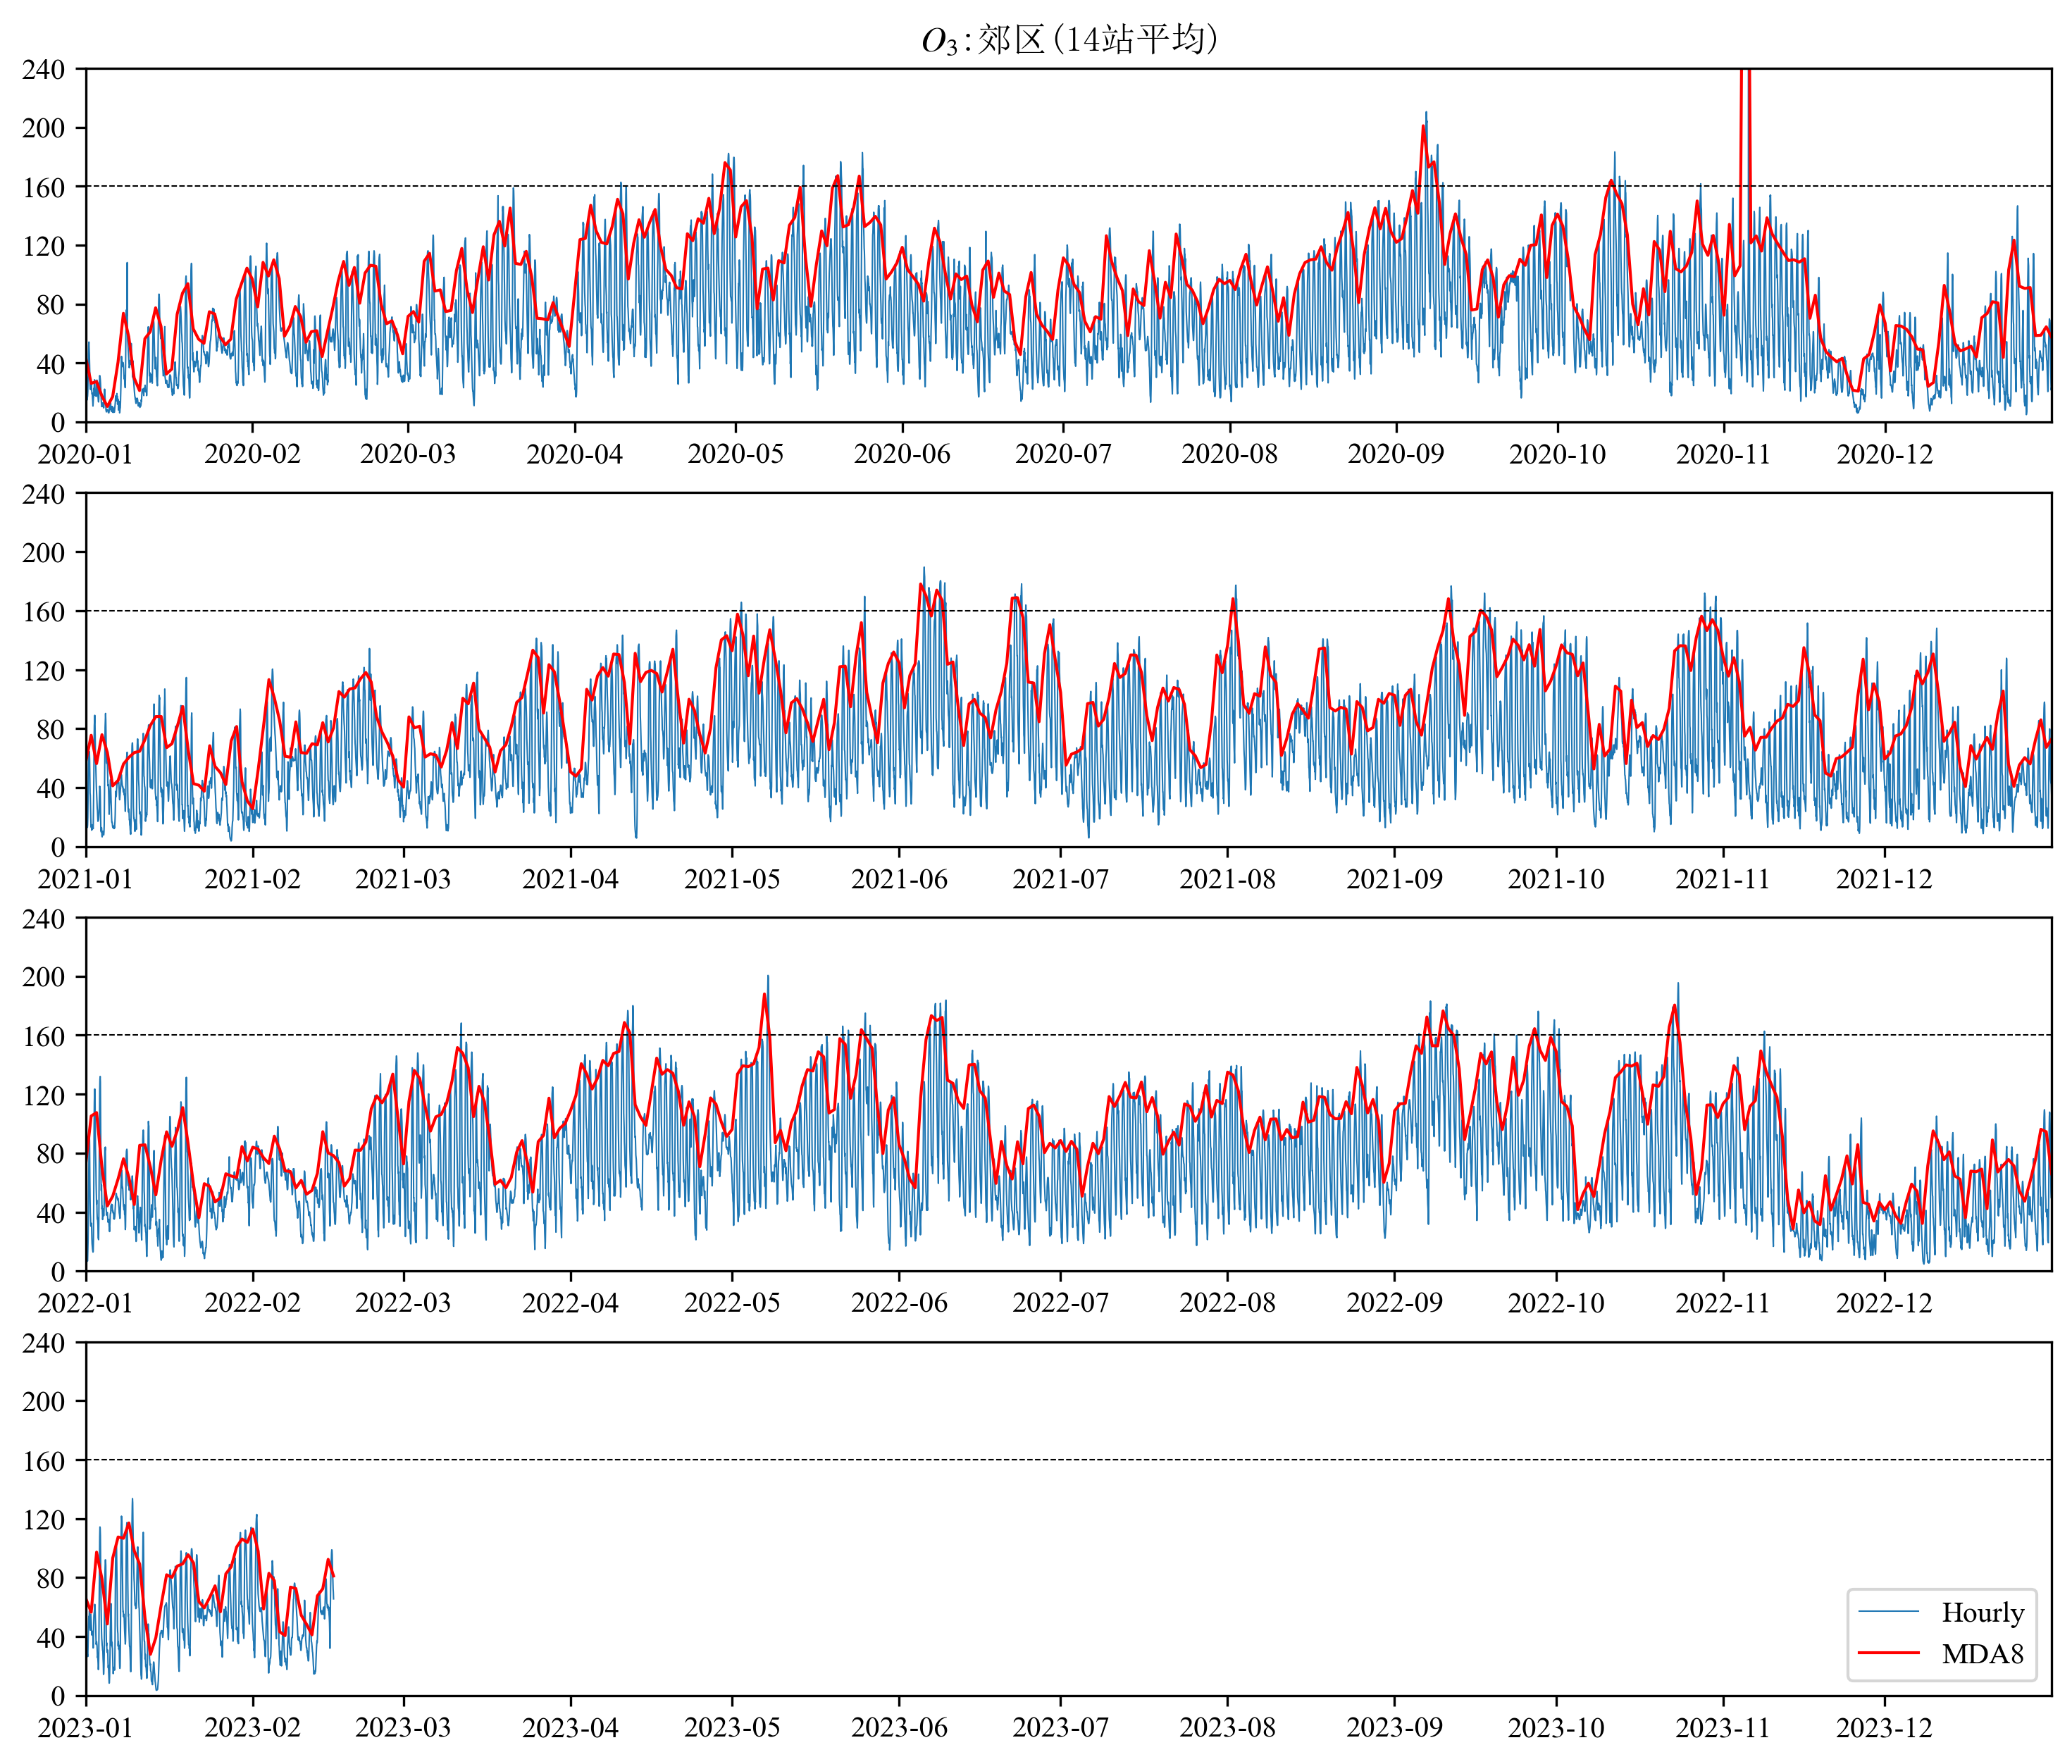

In [11]:
fig=plt.figure(figsize=(12,10),dpi=300)
ax=fig.subplots(4,1)

start_dates = ['2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01']
end_dates = ['2020-12-31', '2021-12-31', '2022-12-31', '2023-12-31']

for i in range(4):
    ax[i].plot(merged_df.index, merged_df['O3'], linewidth=0.5, color='tab:blue',label='Hourly')
    ax[i].plot(mda8_df.index, mda8_df, linewidth=1, color='r',label='MDA8')
    ax[i].set_xlim(pd.to_datetime(start_dates[i] + ' 00'), pd.to_datetime(end_dates[i] + ' 23'))
    ax[i].set_xticks(pd.date_range(start=start_dates[i], end=end_dates[i], freq='M')+pd.Timedelta(1, 'day')-pd.DateOffset(months=1))
    ax[i].set_xticklabels((pd.date_range(start=start_dates[i], end=end_dates[i], freq='M')+pd.Timedelta(1, 'day')-pd.DateOffset(months=1)).strftime('%Y-%m'))

    ax[i].axhline(y=160,linewidth='0.5',linestyle='--',color='k')
    ax[i].set_ylim(0,240)
    ax[i].set_yticks(np.arange(0,241,40))
    # ax[i].set_ylabel('$\mu$$g$/$m^3$')

ax[3].legend(loc=4)
ax[0].set_title('$O_3$:郊区(14站平均)',fontproperties={'family':'SimSun','size':12})
plt.show()

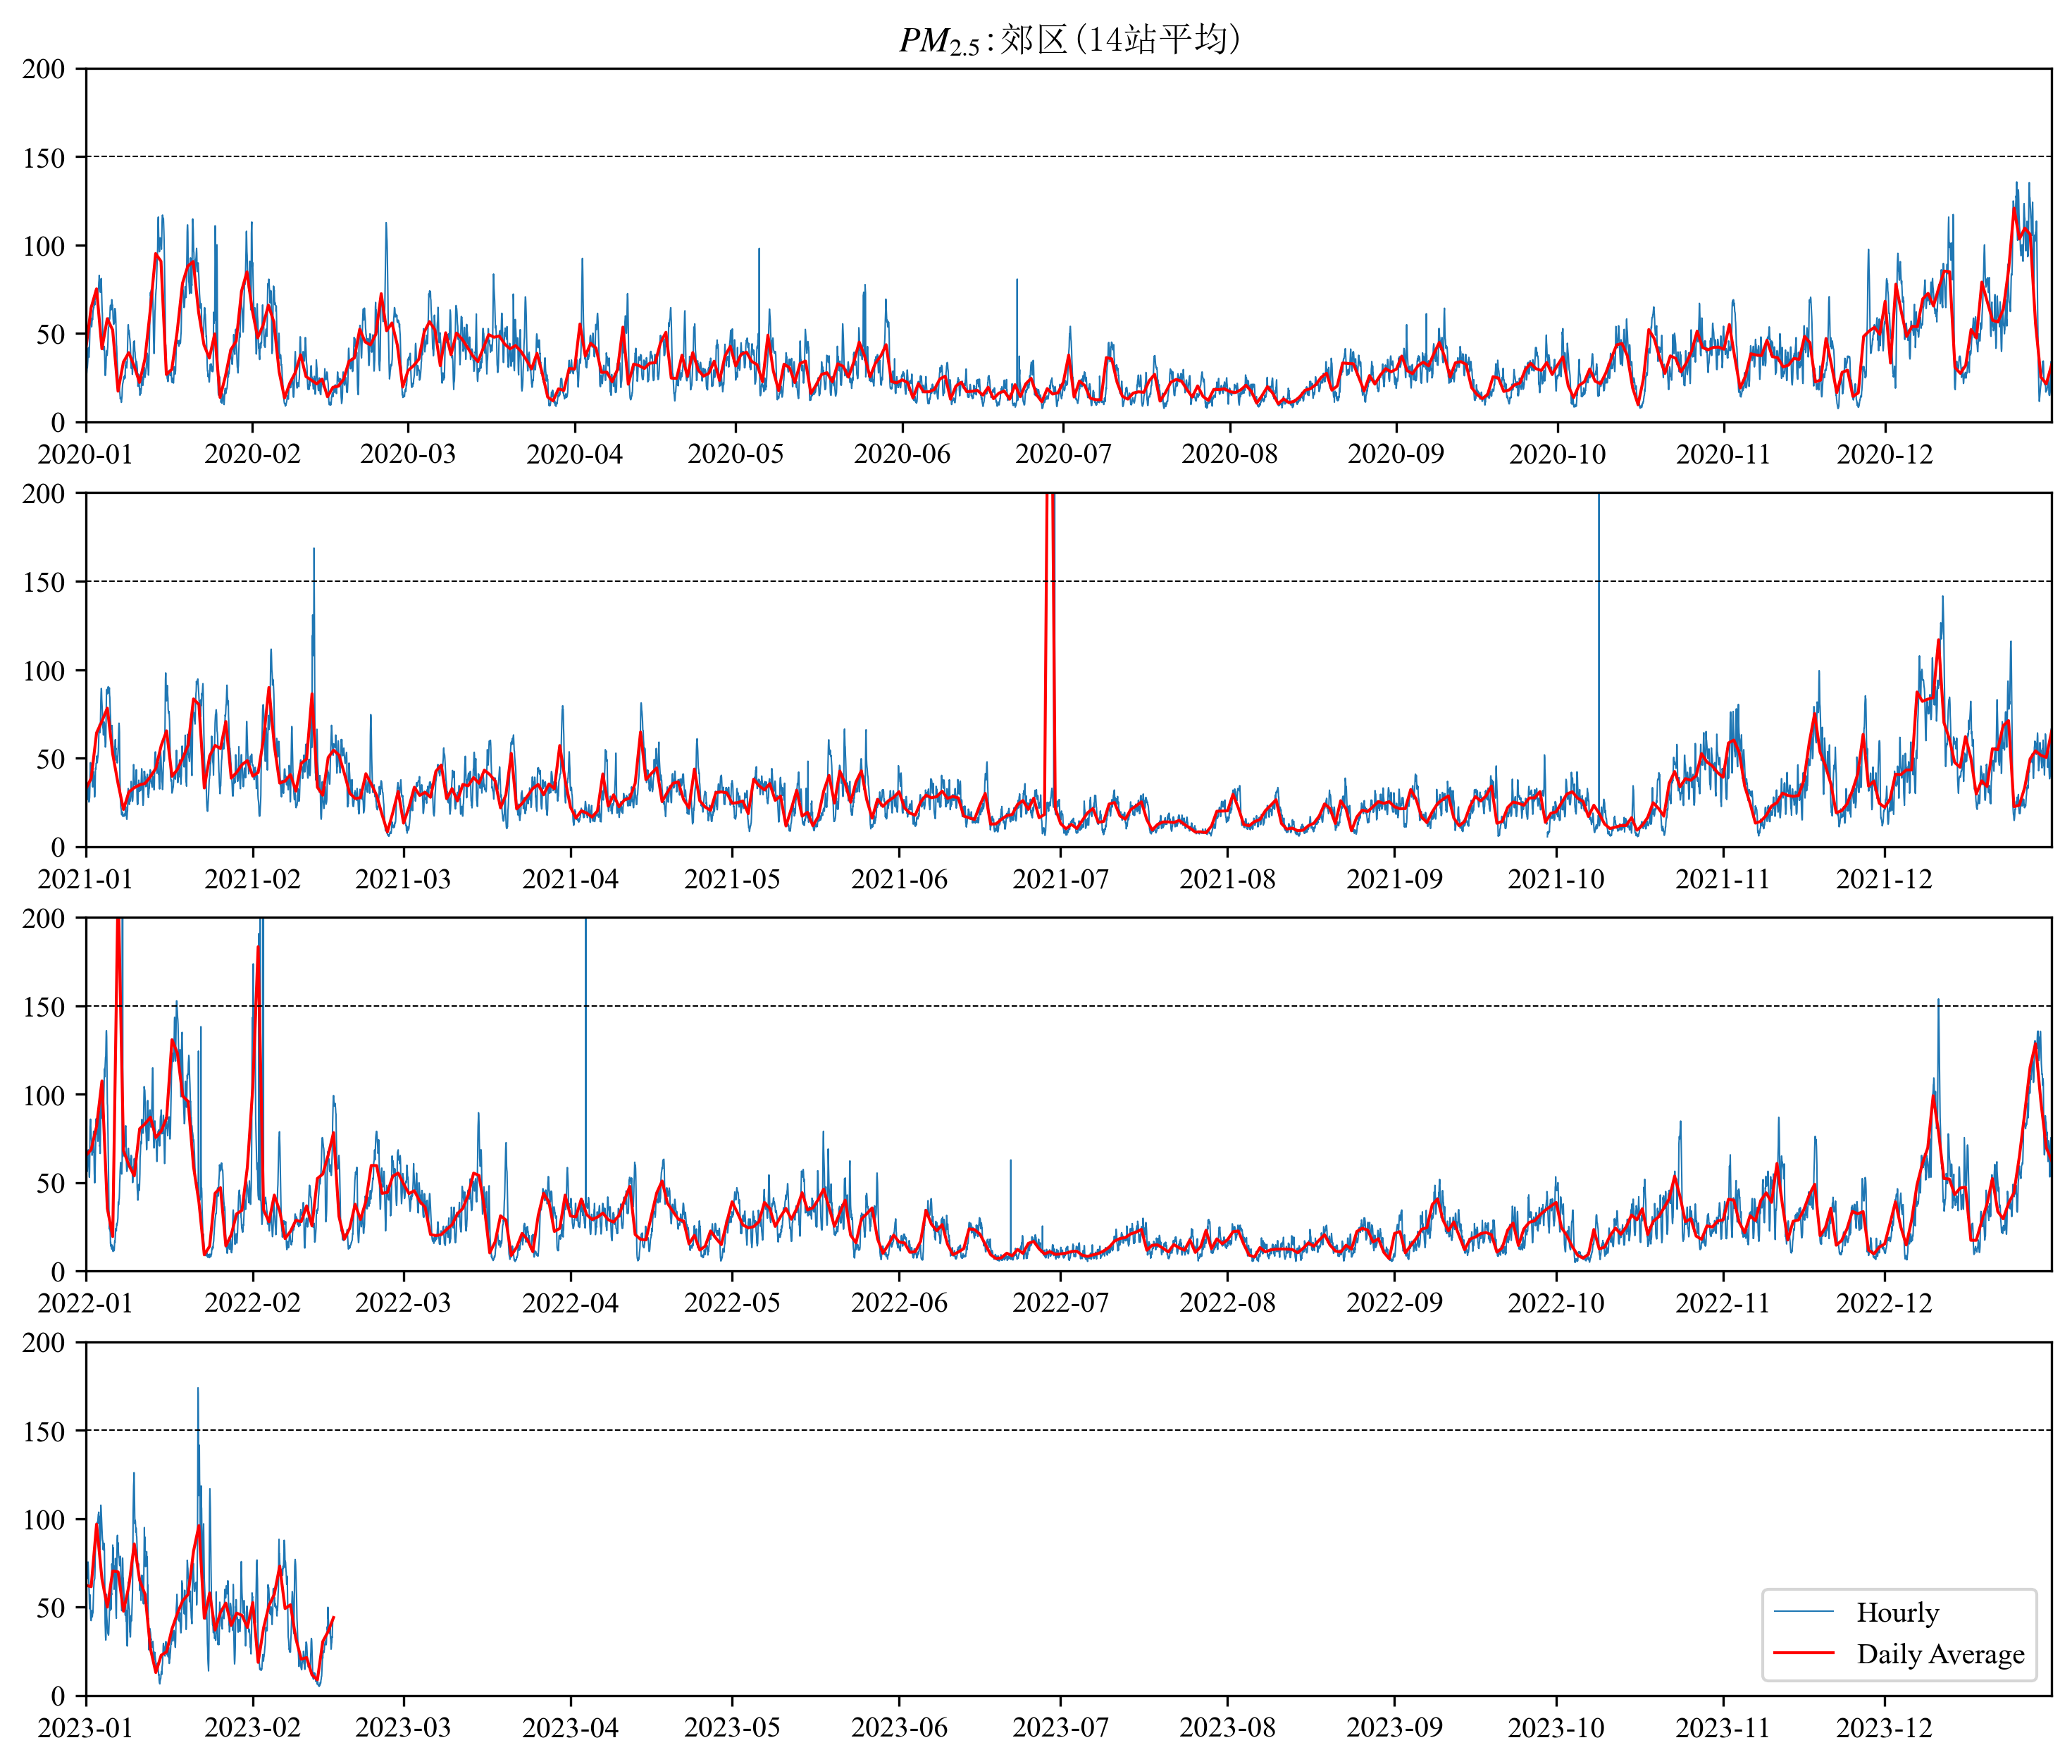

In [14]:
fig=plt.figure(figsize=(12,10),dpi=300)
ax=fig.subplots(4,1)

start_dates = ['2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01']
end_dates = ['2020-12-31', '2021-12-31', '2022-12-31', '2023-12-31']

for i in range(4):
    ax[i].plot(df_PM.index, df_PM, linewidth=0.5, color='tab:blue',label='Hourly')
    ax[i].plot(df_PM_daily.index, df_PM_daily, linewidth=1, color='r',label='Daily Average')
    ax[i].set_xlim(pd.to_datetime(start_dates[i] + ' 00'), pd.to_datetime(end_dates[i] + ' 23'))
    ax[i].set_xticks(pd.date_range(start=start_dates[i], end=end_dates[i], freq='M')+pd.Timedelta(1, 'day')-pd.DateOffset(months=1))
    ax[i].set_xticklabels((pd.date_range(start=start_dates[i], end=end_dates[i], freq='M')+pd.Timedelta(1, 'day')-pd.DateOffset(months=1)).strftime('%Y-%m'))

    ax[i].axhline(y=150,linewidth='0.5',linestyle='--',color='k')
    ax[i].set_ylim(0,200)
    ax[i].set_yticks(np.arange(0,201,50))
    # ax[i].set_ylabel('$\mu$$g$/$m^3$')

ax[3].legend(loc=4)
ax[0].set_title('$PM_{2.5}$:郊区(14站平均)',fontproperties={'family':'SimSun','size':12})
plt.show()

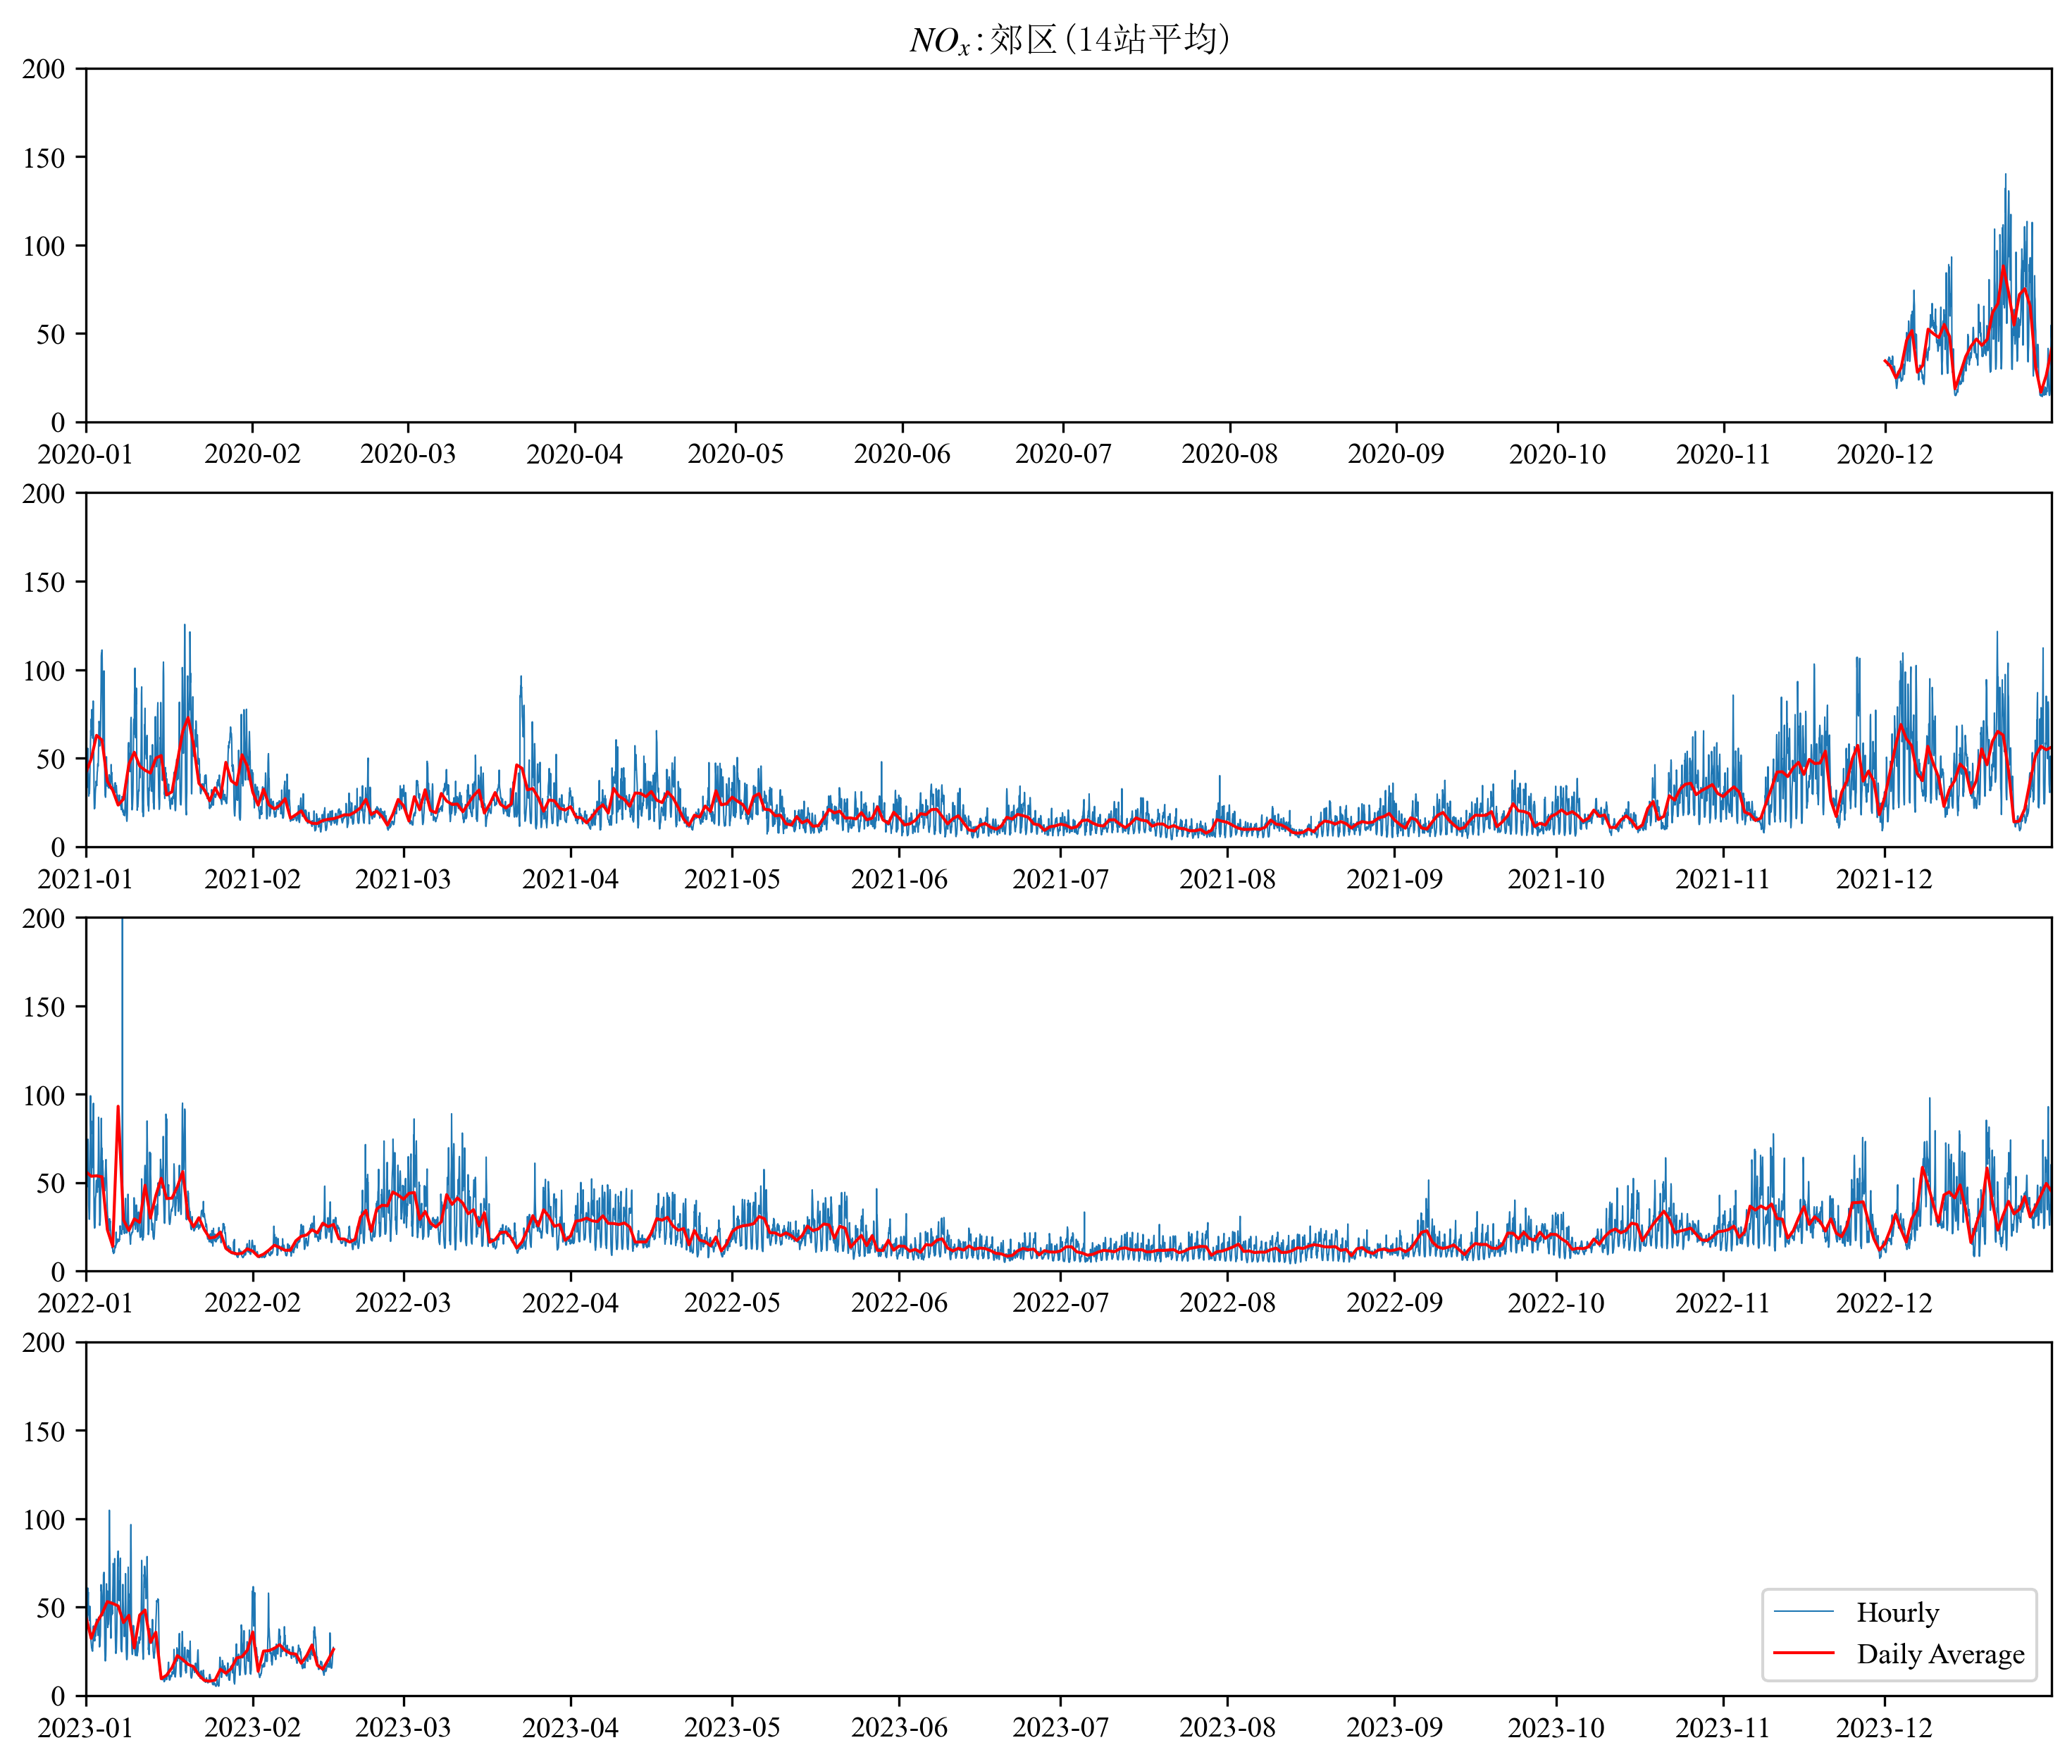

In [15]:
fig=plt.figure(figsize=(12,10),dpi=300)
ax=fig.subplots(4,1)

start_dates = ['2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01']
end_dates = ['2020-12-31', '2021-12-31', '2022-12-31', '2023-12-31']

for i in range(4):
    ax[i].plot(df_NOx.index, df_NOx, linewidth=0.5, color='tab:blue',label='Hourly')
    ax[i].plot(df_NOx_daily.index, df_NOx_daily, linewidth=1, color='r',label='Daily Average')
    ax[i].set_xlim(pd.to_datetime(start_dates[i] + ' 00'), pd.to_datetime(end_dates[i] + ' 23'))
    ax[i].set_xticks(pd.date_range(start=start_dates[i], end=end_dates[i], freq='M')+pd.Timedelta(1, 'day')-pd.DateOffset(months=1))
    ax[i].set_xticklabels((pd.date_range(start=start_dates[i], end=end_dates[i], freq='M')+pd.Timedelta(1, 'day')-pd.DateOffset(months=1)).strftime('%Y-%m'))

    # ax[i].axhline(y=150,linewidth='0.5',linestyle='--',color='k')
    ax[i].set_ylim(0,200)
    ax[i].set_yticks(np.arange(0,201,50))
    # ax[i].set_ylabel('$\mu$$g$/$m^3$')

ax[3].legend(loc=4)
ax[0].set_title('$NO_x$:郊区(14站平均)',fontproperties={'family':'SimSun','size':12})
plt.show()

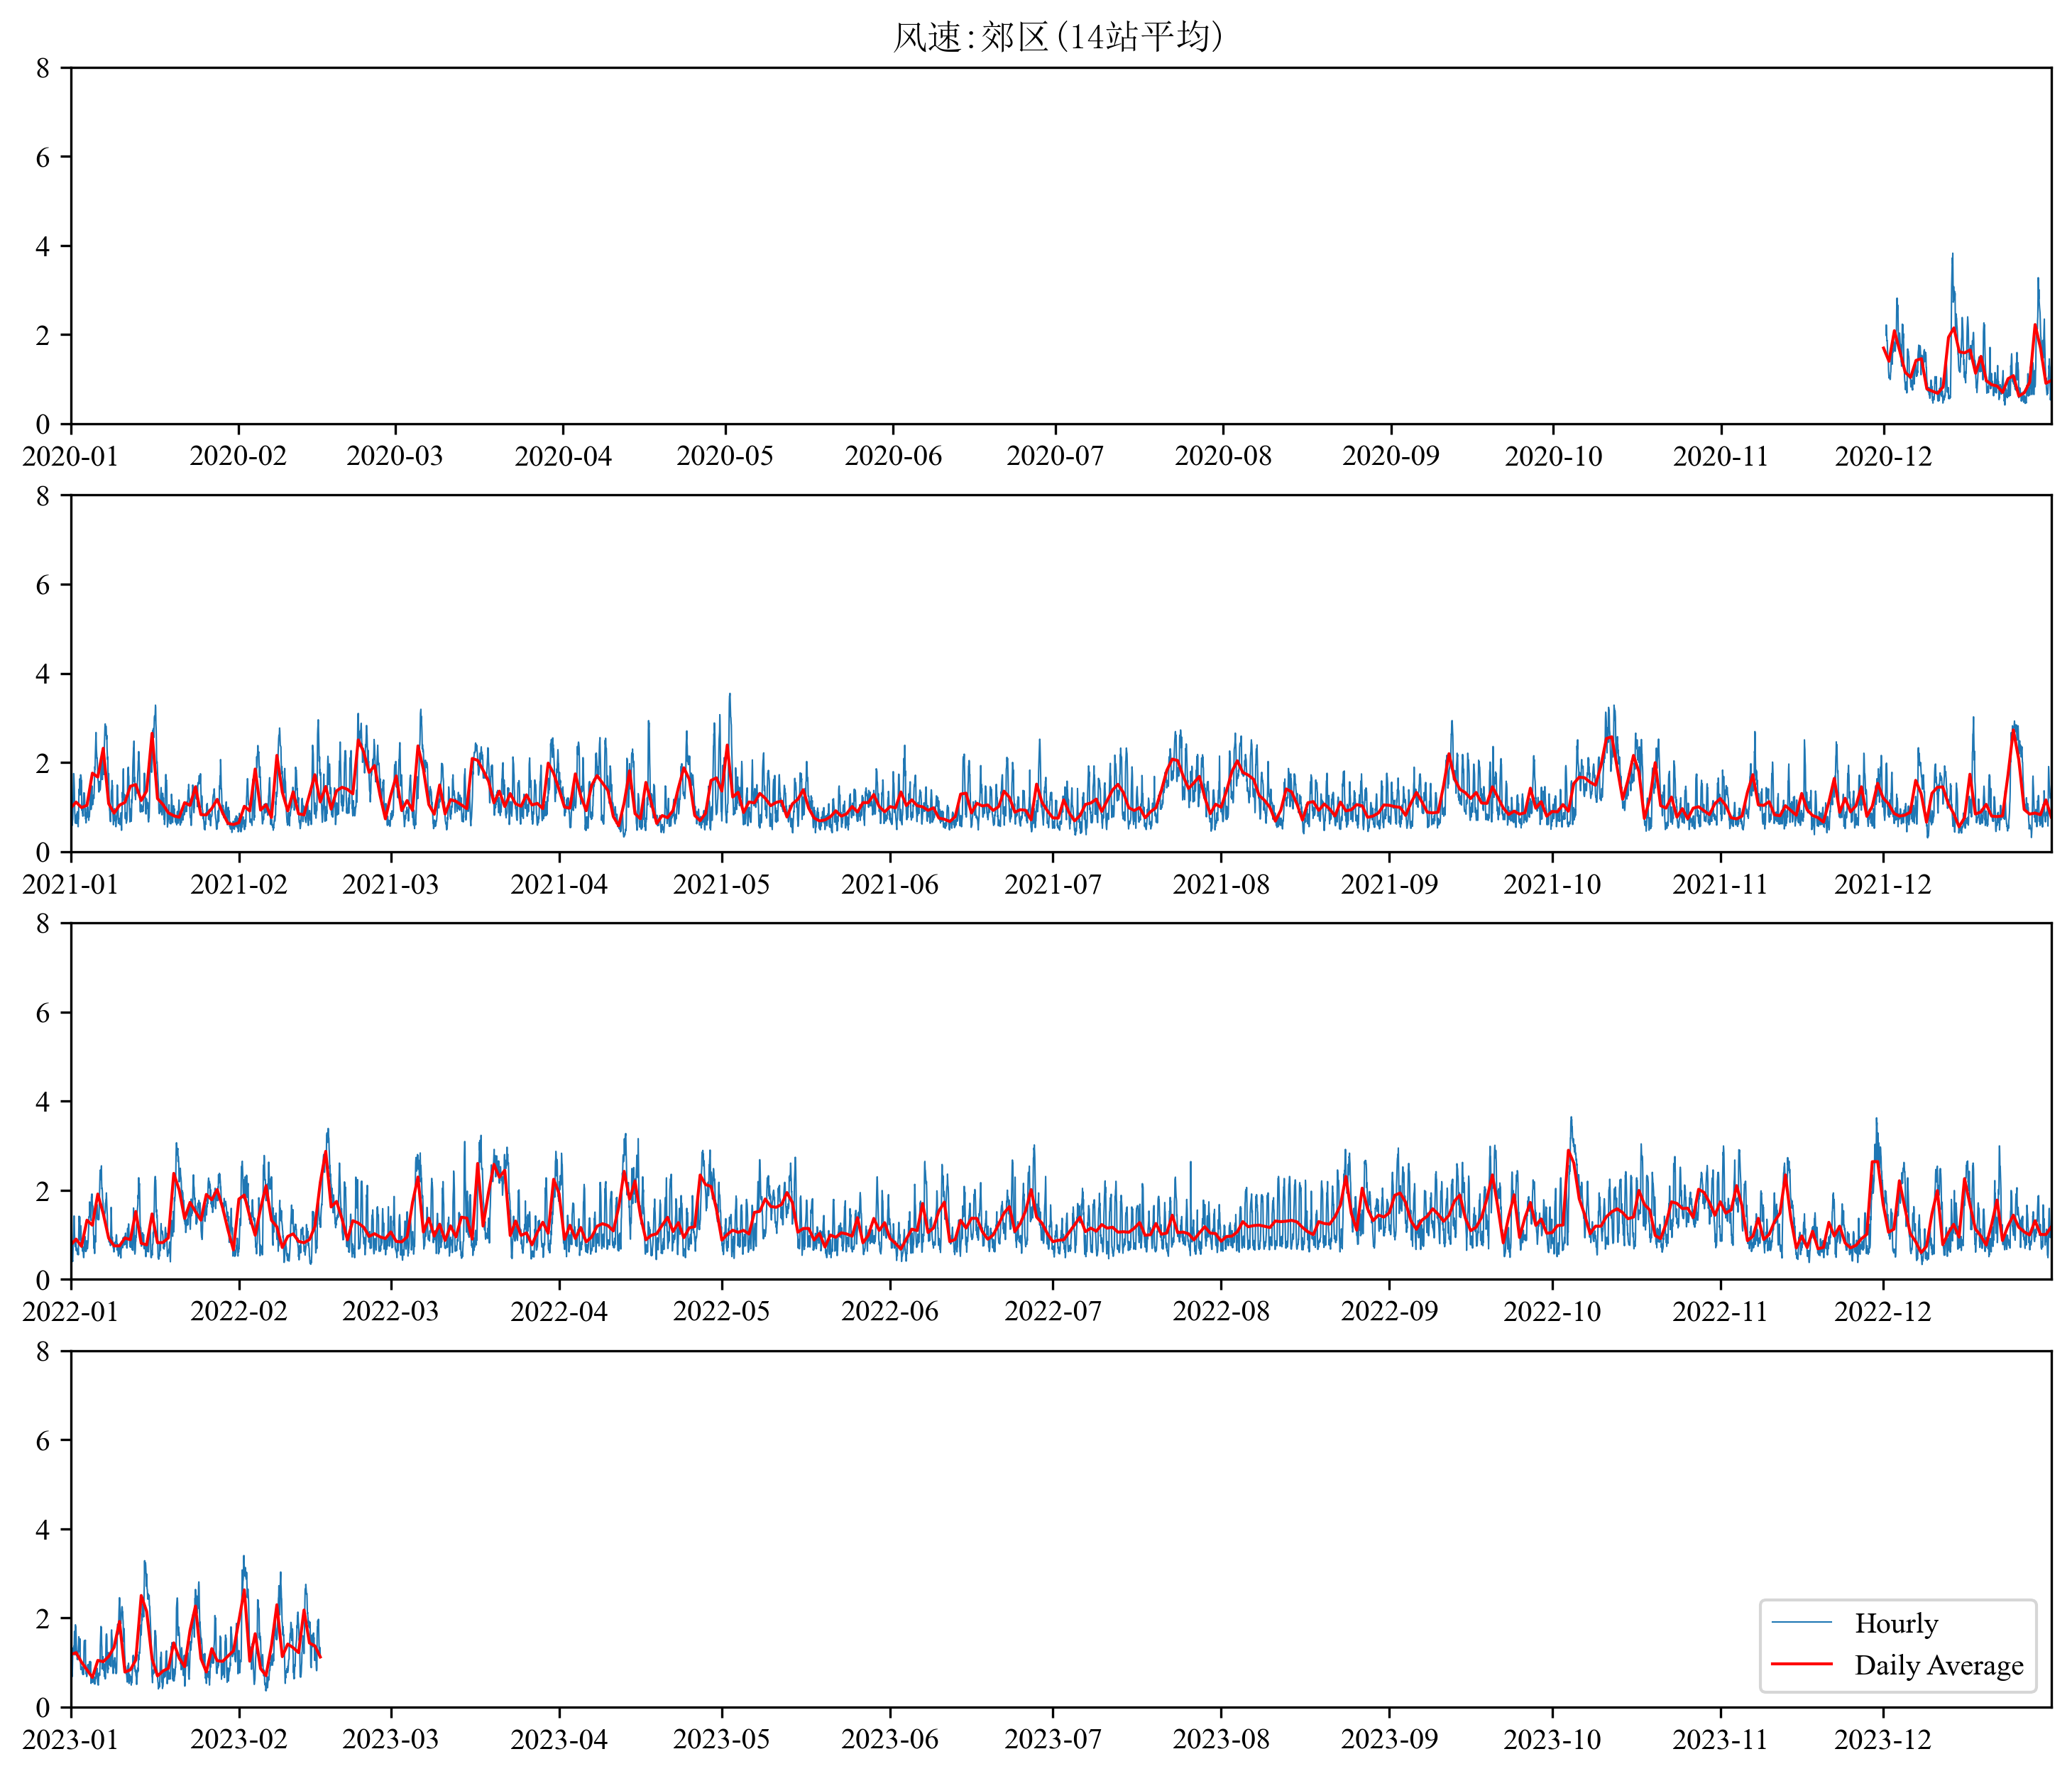

In [16]:
fig=plt.figure(figsize=(12,10),dpi=300)
ax=fig.subplots(4,1)

start_dates = ['2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01']
end_dates = ['2020-12-31', '2021-12-31', '2022-12-31', '2023-12-31']

for i in range(4):
    ax[i].plot(df_ws.index, df_ws, linewidth=0.5, color='tab:blue',label='Hourly')
    ax[i].plot(df_ws_daily.index, df_ws_daily, linewidth=1, color='r',label='Daily Average')
    ax[i].set_xlim(pd.to_datetime(start_dates[i] + ' 00'), pd.to_datetime(end_dates[i] + ' 23'))
    ax[i].set_xticks(pd.date_range(start=start_dates[i], end=end_dates[i], freq='M')+pd.Timedelta(1, 'day')-pd.DateOffset(months=1))
    ax[i].set_xticklabels((pd.date_range(start=start_dates[i], end=end_dates[i], freq='M')+pd.Timedelta(1, 'day')-pd.DateOffset(months=1)).strftime('%Y-%m'))

    # ax[i].axhline(y=150,linewidth='0.5',linestyle='--',color='k')
    ax[i].set_ylim(0,8)
    ax[i].set_yticks(np.arange(0,8.1,2))
    # ax[i].set_ylabel('$\mu$$g$/$m^3$')

ax[3].legend(loc=4)
ax[0].set_title('风速:郊区(14站平均)',fontproperties={'family':'SimSun','size':12})
plt.show()

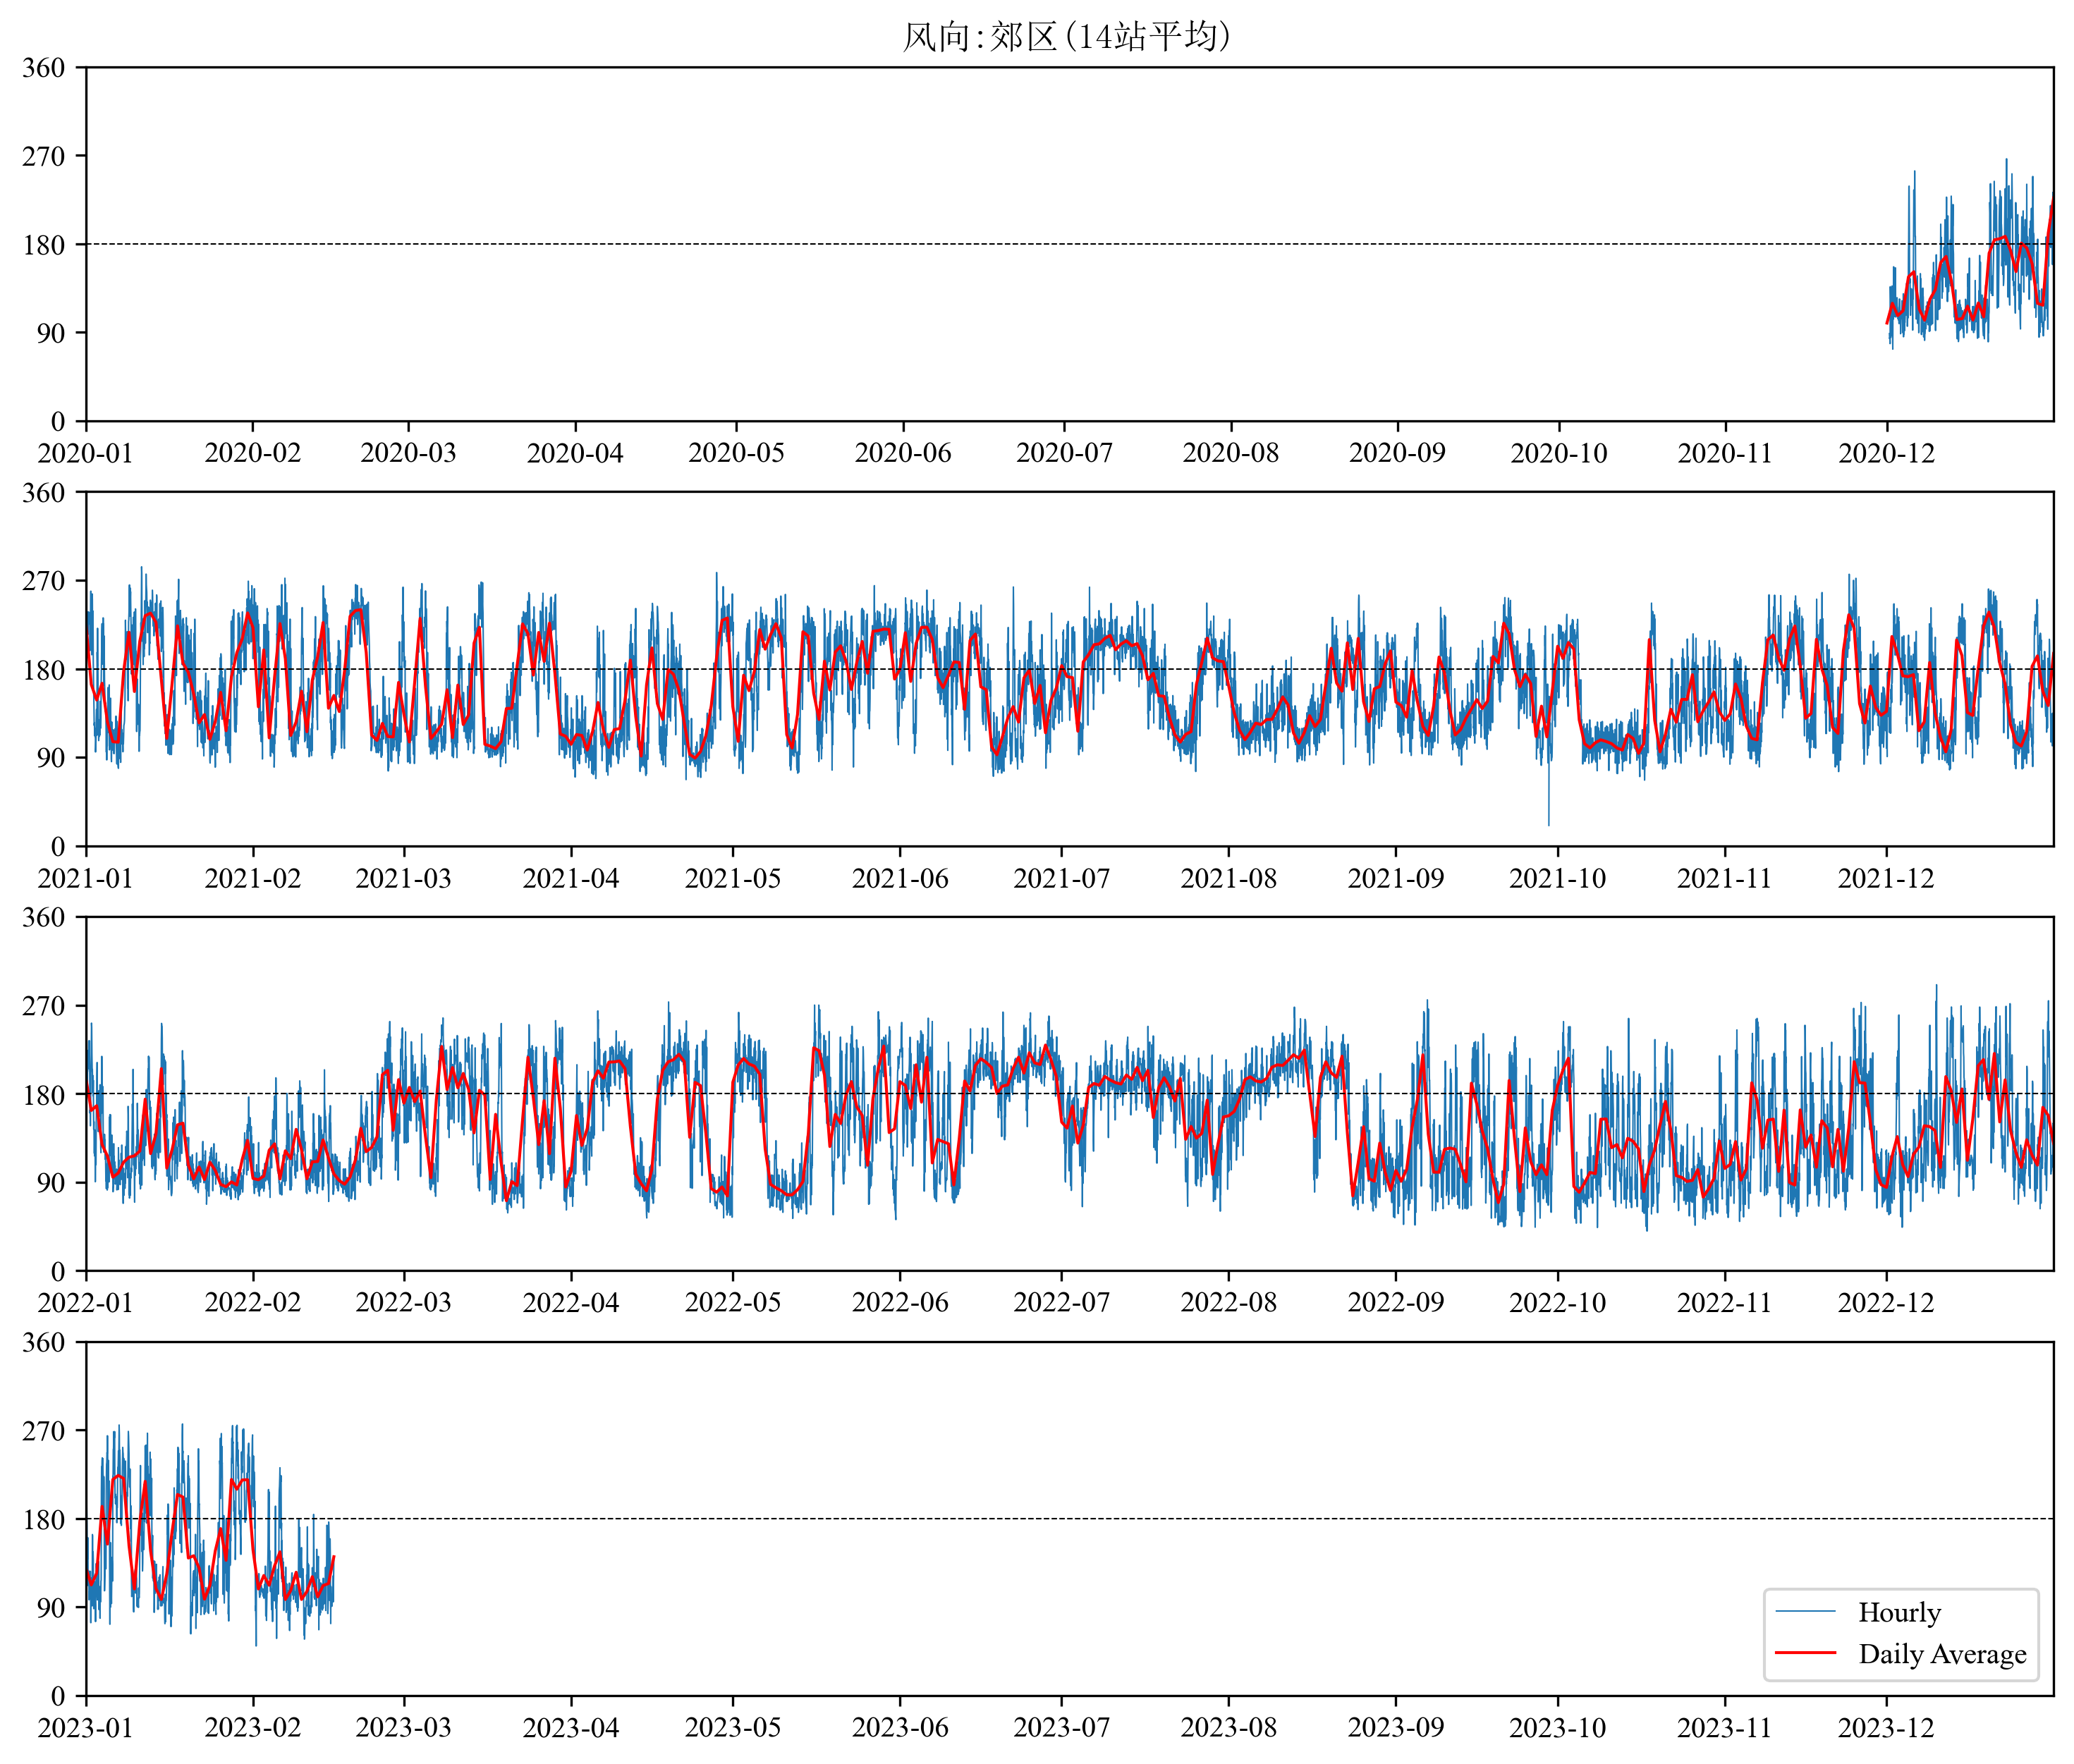

In [17]:
fig=plt.figure(figsize=(12,10),dpi=300)
ax=fig.subplots(4,1)

start_dates = ['2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01']
end_dates = ['2020-12-31', '2021-12-31', '2022-12-31', '2023-12-31']

for i in range(4):
    ax[i].plot(df_wd.index, df_wd, linewidth=0.5, color='tab:blue',label='Hourly')
    ax[i].plot(df_wd_daily.index, df_wd_daily, linewidth=1, color='r',label='Daily Average')
    ax[i].set_xlim(pd.to_datetime(start_dates[i] + ' 00'), pd.to_datetime(end_dates[i] + ' 23'))
    ax[i].set_xticks(pd.date_range(start=start_dates[i], end=end_dates[i], freq='M')+pd.Timedelta(1, 'day')-pd.DateOffset(months=1))
    ax[i].set_xticklabels((pd.date_range(start=start_dates[i], end=end_dates[i], freq='M')+pd.Timedelta(1, 'day')-pd.DateOffset(months=1)).strftime('%Y-%m'))

    ax[i].axhline(y=180,linewidth='0.5',linestyle='--',color='k')
    ax[i].set_ylim(0,360)
    ax[i].set_yticks(np.arange(0,361,90))
    # ax[i].set_ylabel('$\mu$$g$/$m^3$')

ax[3].legend(loc=4)
ax[0].set_title('风向:郊区(14站平均)',fontproperties={'family':'SimSun','size':12})
plt.show()

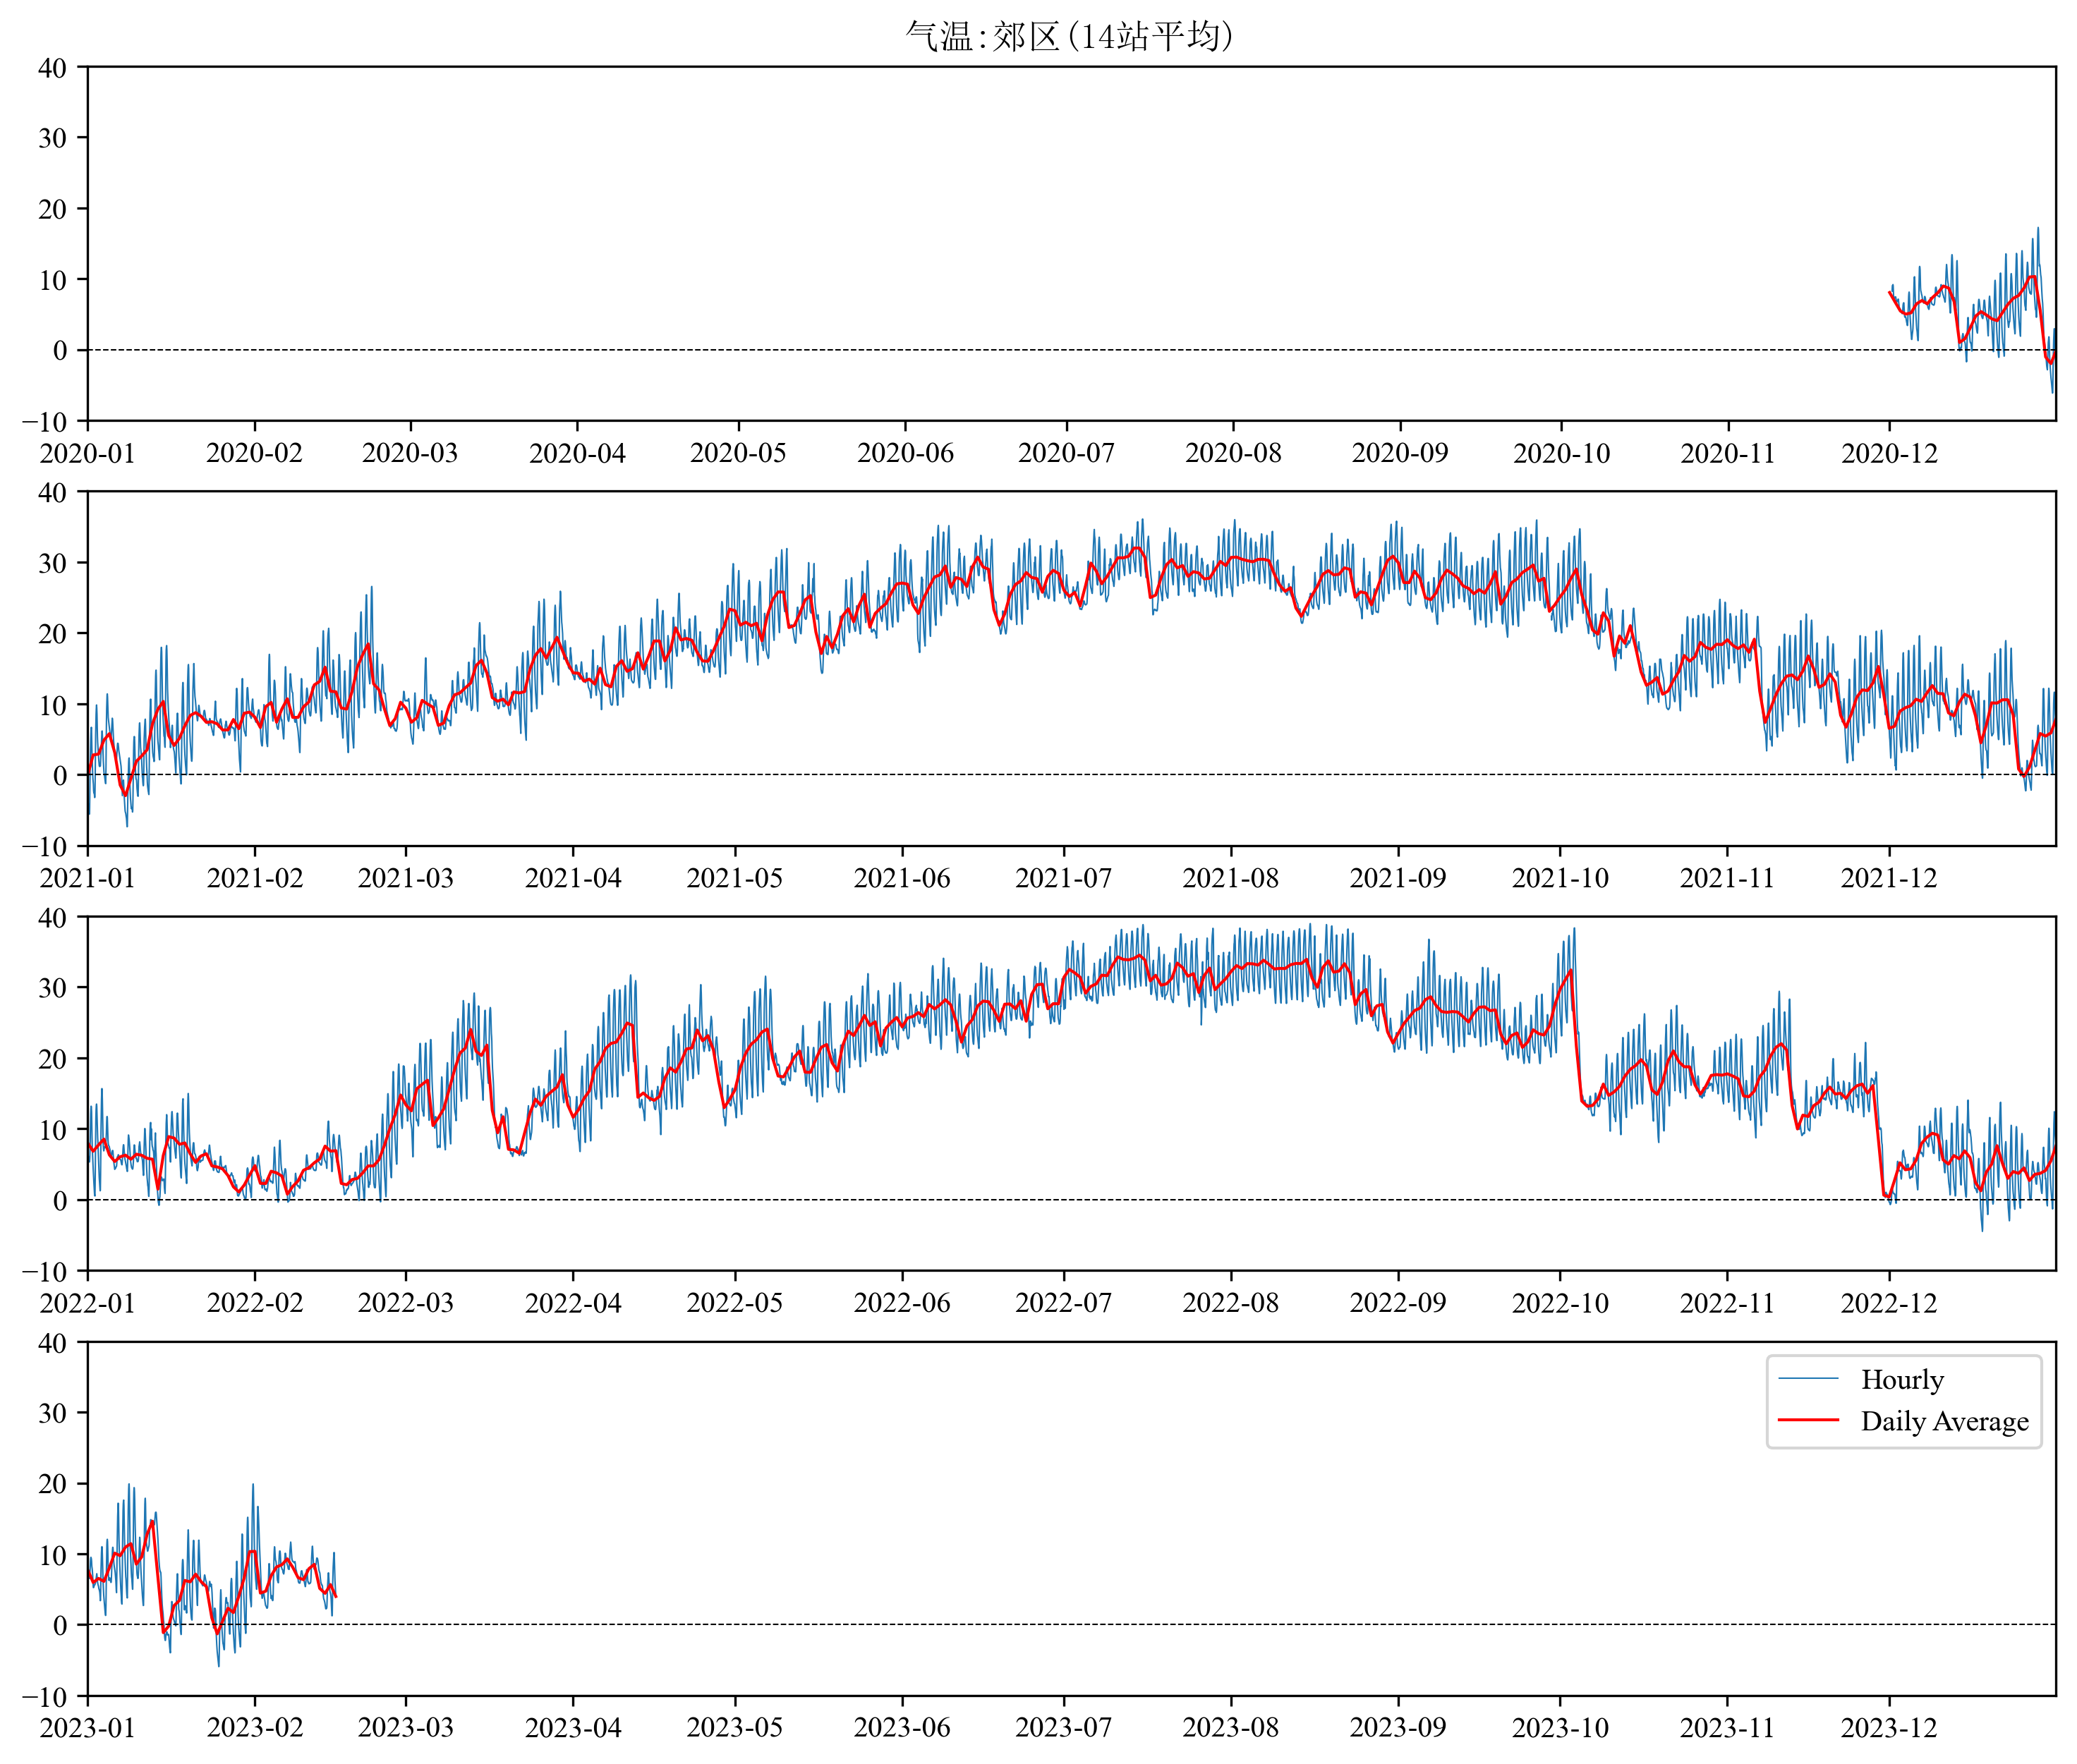

In [18]:
fig=plt.figure(figsize=(12,10),dpi=300)
ax=fig.subplots(4,1)

start_dates = ['2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01']
end_dates = ['2020-12-31', '2021-12-31', '2022-12-31', '2023-12-31']

for i in range(4):
    ax[i].plot(df_temp.index, df_temp, linewidth=0.5, color='tab:blue',label='Hourly')
    ax[i].plot(df_temp_daily.index, df_temp_daily, linewidth=1, color='r',label='Daily Average')
    ax[i].set_xlim(pd.to_datetime(start_dates[i] + ' 00'), pd.to_datetime(end_dates[i] + ' 23'))
    ax[i].set_xticks(pd.date_range(start=start_dates[i], end=end_dates[i], freq='M')+pd.Timedelta(1, 'day')-pd.DateOffset(months=1))
    ax[i].set_xticklabels((pd.date_range(start=start_dates[i], end=end_dates[i], freq='M')+pd.Timedelta(1, 'day')-pd.DateOffset(months=1)).strftime('%Y-%m'))

    ax[i].axhline(y=0,linewidth='0.5',linestyle='--',color='k')
    ax[i].set_ylim(-10,40)
    ax[i].set_yticks(np.arange(-10,41,10))
    # ax[i].set_ylabel('$\mu$$g$/$m^3$')

ax[3].legend(loc=1)
ax[0].set_title('气温:郊区(14站平均)',fontproperties={'family':'SimSun','size':12})
plt.show()

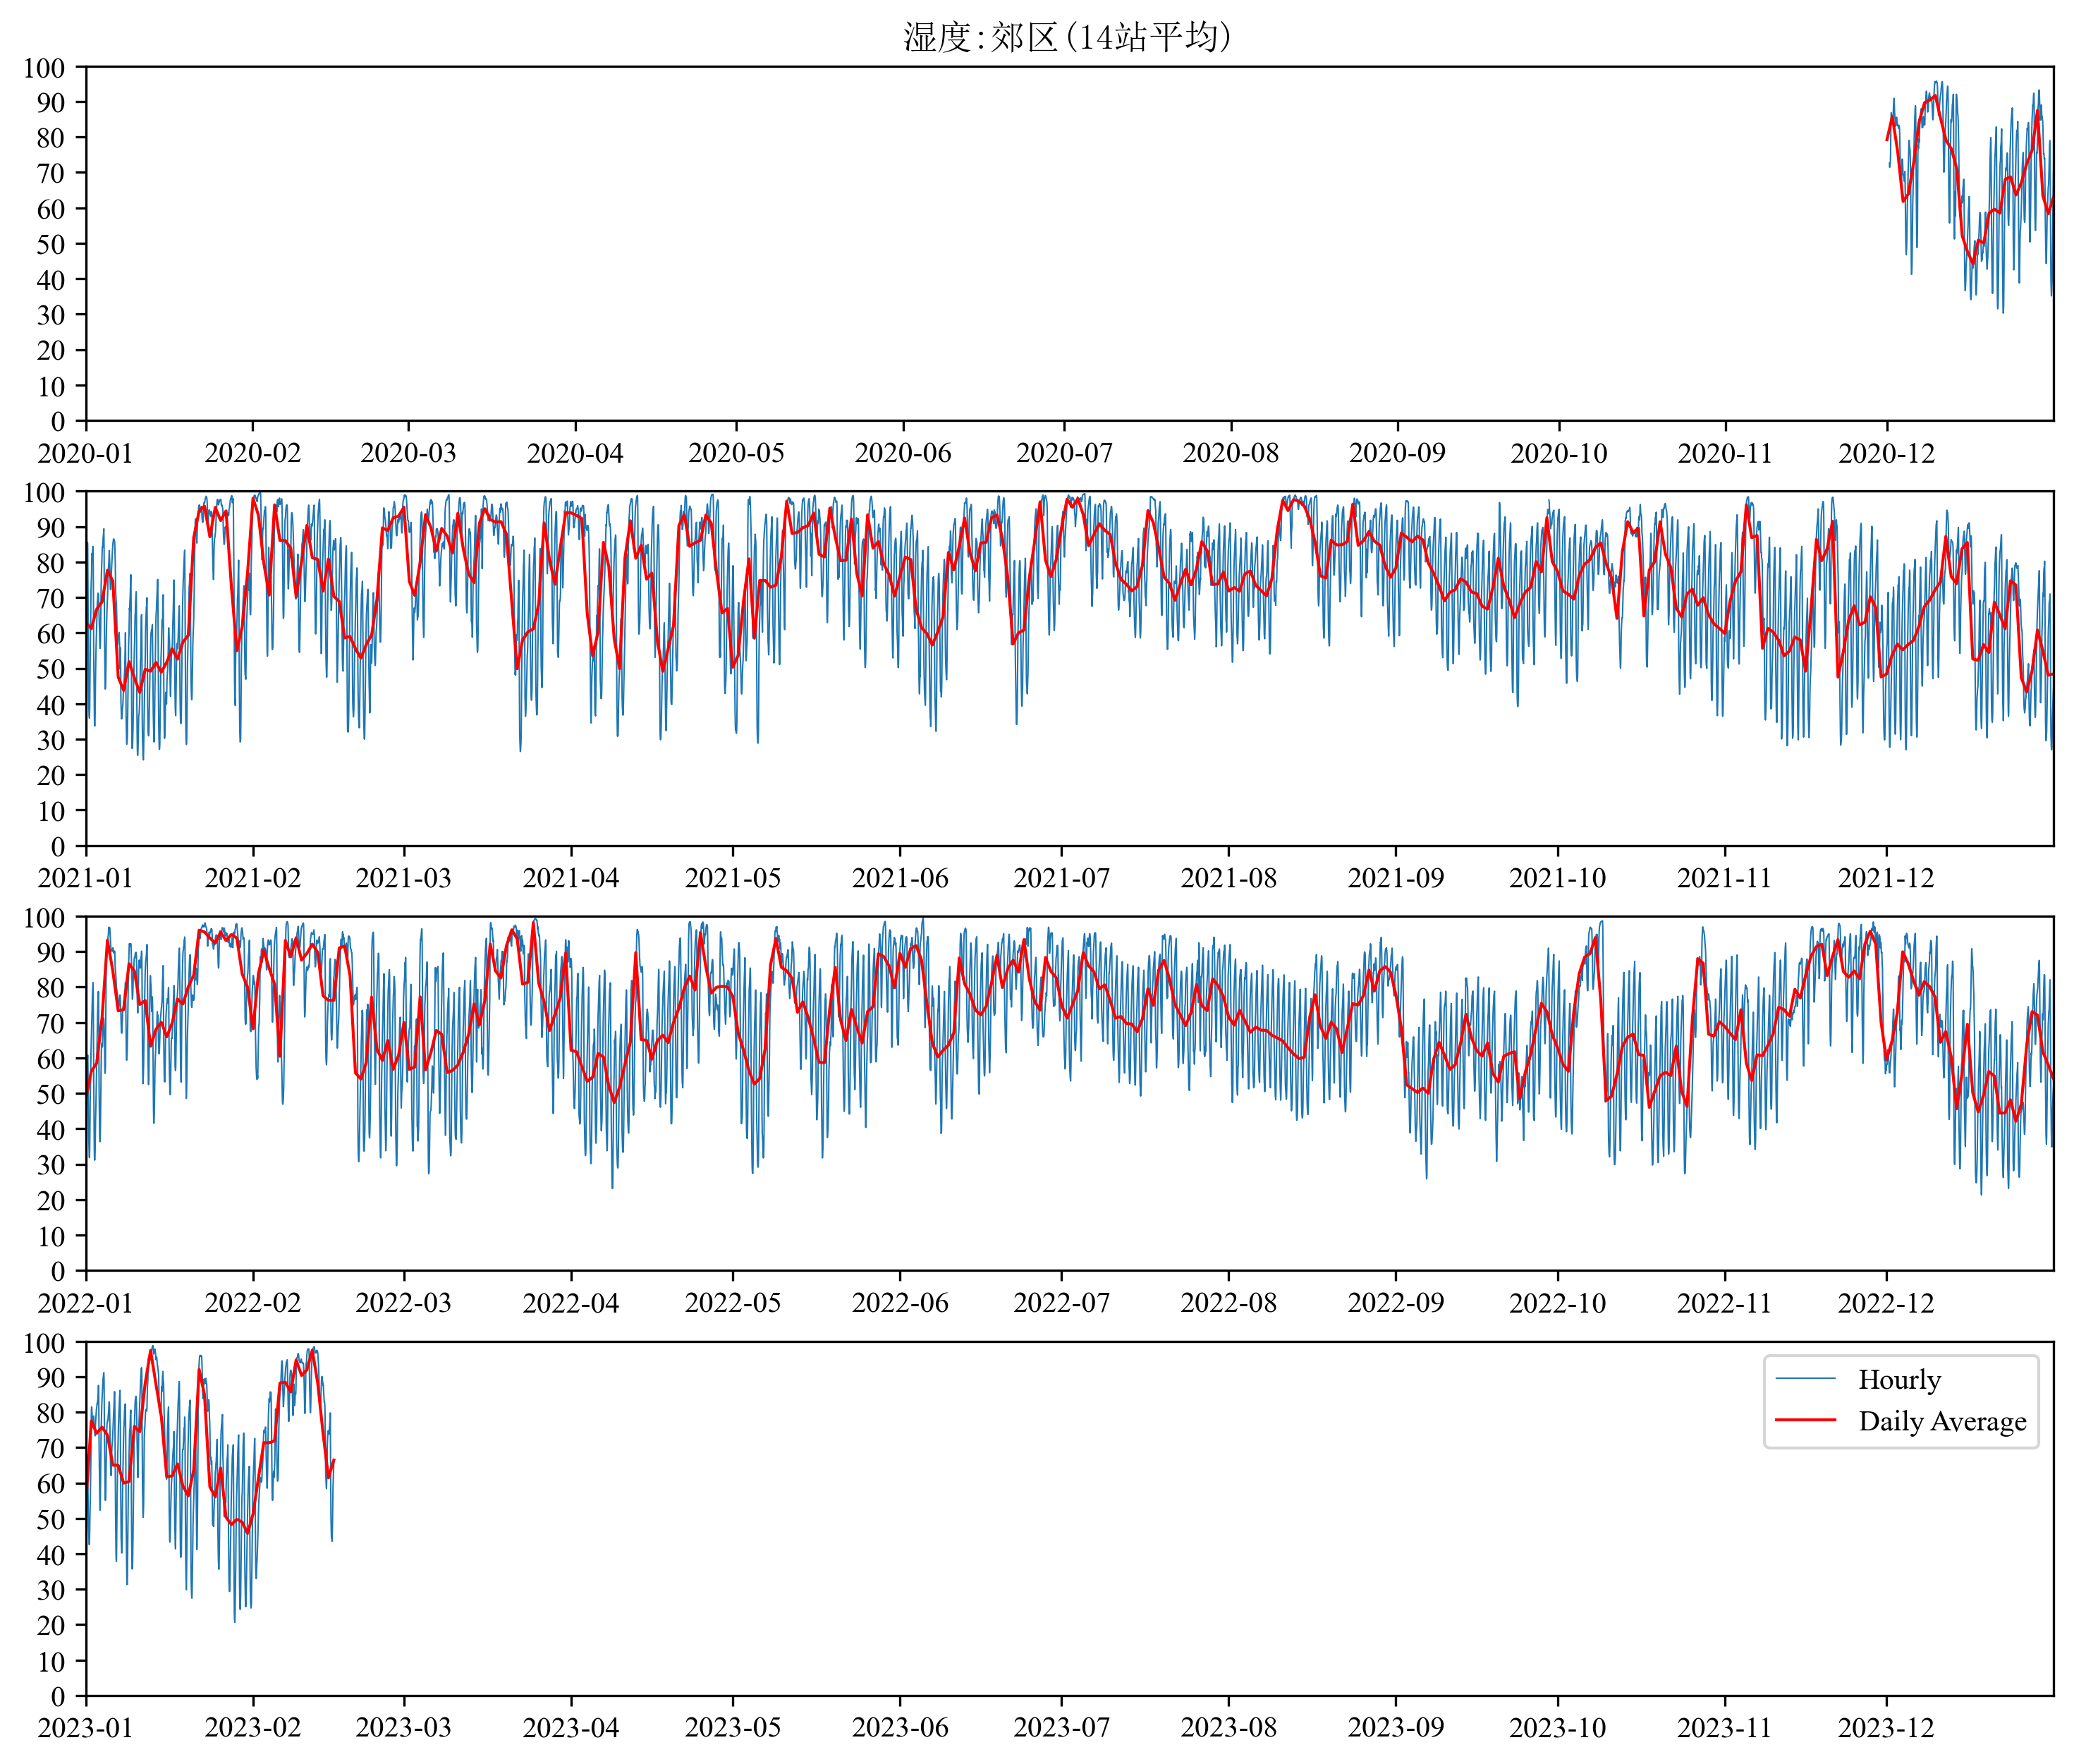

In [19]:
fig=plt.figure(figsize=(12,10),dpi=300)
ax=fig.subplots(4,1)

start_dates = ['2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01']
end_dates = ['2020-12-31', '2021-12-31', '2022-12-31', '2023-12-31']

for i in range(4):
    ax[i].plot(df_rh.index, df_rh, linewidth=0.5, color='tab:blue',label='Hourly')
    ax[i].plot(df_rh_daily.index, df_rh_daily, linewidth=1, color='r',label='Daily Average')
    ax[i].set_xlim(pd.to_datetime(start_dates[i] + ' 00'), pd.to_datetime(end_dates[i] + ' 23'))
    ax[i].set_xticks(pd.date_range(start=start_dates[i], end=end_dates[i], freq='M')+pd.Timedelta(1, 'day')-pd.DateOffset(months=1))
    ax[i].set_xticklabels((pd.date_range(start=start_dates[i], end=end_dates[i], freq='M')+pd.Timedelta(1, 'day')-pd.DateOffset(months=1)).strftime('%Y-%m'))

    # ax[i].axhline(y=0,linewidth='0.5',linestyle='--',color='k')
    ax[i].set_ylim(0,100)
    ax[i].set_yticks(np.arange(0,101,10))
    # ax[i].set_ylabel('$\mu$$g$/$m^3$')

ax[3].legend(loc=1)
ax[0].set_title('湿度:郊区(14站平均)',fontproperties={'family':'SimSun','size':12})
plt.show()